<a href="https://colab.research.google.com/github/arazm21/ML-homework_4/blob/main/expression_notebook_second.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# loading the data and organising it

In [2]:
! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge

Mounted at /content/drive
 93% 266M/285M [00:00<00:00, 519MB/s]
100% 285M/285M [00:00<00:00, 565MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [3]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 18.9 MB/s eta 0:00:00


In [4]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [5]:
import torch
from torch.utils.data import Dataset, Subset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Subset

class ExpressionDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, indices=None):
        self.data = pd.read_csv(csv_file)

        if indices is not None:
            self.data = self.data.iloc[indices].reset_index(drop=True)

        self.images = self.data['pixels'].apply(
            lambda x: np.fromstring(x, sep=' ', dtype=np.uint8).reshape(48, 48)
        )
        self.images = torch.tensor(np.stack(self.images.values), dtype=torch.float32).unsqueeze(1) / 255.0
        self.labels = torch.tensor(self.data['emotion'].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


def get_data(csv_file="train.csv", slice=5, train=True, val_ratio=0.2, random_state=42):
    # Load full train.csv data
    full_data = pd.read_csv(csv_file)
    indices = list(range(len(full_data)))

    # Stratified split indices for train/validation
    train_indices, val_indices = train_test_split(
        indices,
        test_size=val_ratio,
        stratify=full_data['emotion'],
        random_state=random_state
    )

    # Select which indices to use
    selected_indices = train_indices if train else val_indices

    # Create dataset with selected indices
    dataset = ExpressionDataset(csv_file, indices=selected_indices)

    # Slice dataset if requested
    sliced_indices = list(range(0, len(dataset), slice))
    return Subset(dataset, sliced_indices)


def make_loader(dataset, batch_size):
    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        pin_memory=True,
                        num_workers=2)
    return loader


## test that loading was ok

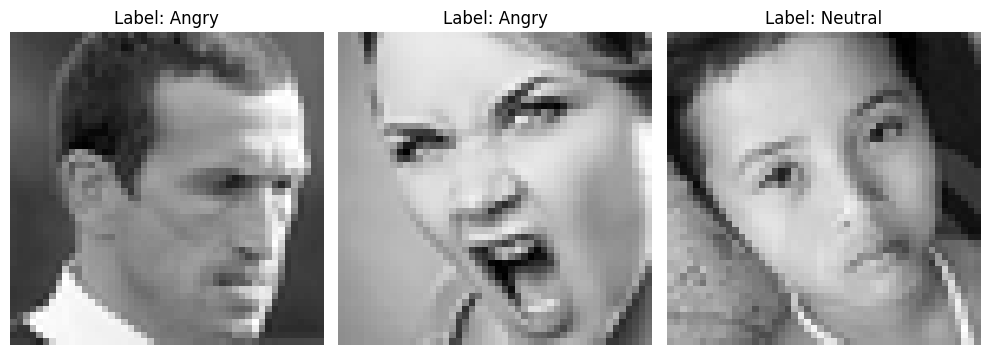

In [6]:
# Load and create loader
dataset = get_data(slice=1, train=False)
loader = make_loader(dataset, batch_size=3)

# Get a batch
images, labels = next(iter(loader))

# Class names from FER2013
emotion_names = [
    "Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"
]

# Plot the first 3 images
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {emotion_names[labels[i].item()]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# connecting WANDB

In [7]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [8]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arazm21 (arazm21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# different attempted architectures

## convnet

In [ ]:
# import torch.nn as nn

# class ConvNet_super_simple(nn.Module):
#     def __init__(self, kernels, classes=7):
#         super(ConvNet_super_simple, self).__init__()

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#         # Assuming 48x48 input, after two 2x2 poolings -> 48/2/2 = 12x12
#         self.fc = nn.Linear(12 * 12 * kernels[1], classes)

#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out
import torch
import torch.nn as nn

class ConvNet_Improved(nn.Module):
    def __init__(self, kernels, classes=7):
        super(ConvNet_Improved, self).__init__()

        # First conv block
        self.conv1 = nn.Conv2d(1, kernels[0], kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(kernels[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second conv block
        self.conv2 = nn.Conv2d(kernels[0], kernels[1], kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(kernels[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third conv block
        self.conv3 = nn.Conv2d(kernels[1], kernels[2], kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(kernels[2])
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Assuming 48x48 input → 3 poolings: 48 → 24 → 12 → 6
        self.flattened_dim = 6 * 6 * kernels[2]
        self.fc = nn.Linear(self.flattened_dim, classes)

    def forward(self, x):
        x = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(self.relu3(self.bn3(self.conv3(x)))))

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


## resnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, dropout_rate=0.2):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        self.dropout = nn.Dropout2d(dropout_rate)

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.dropout(out)  # ✅ Dropout after residual addition
        out += identity
        out = F.relu(out)

        return out

class SimpleResNet15(nn.Module):
    def __init__(self, in_channels=1, num_classes=7, dropout_rate=0.34):
        super(SimpleResNet15, self).__init__()

        self.entry = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layers = nn.Sequential(
            ResidualBlock(64, 128, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(128, 256, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(256, 512, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(512, 1024, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(1024, 2048, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(2048, 2048, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(2048, 1024, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(1024, 512, downsample=True, dropout_rate=dropout_rate),
            ResidualBlock(512, 256, downsample=True, dropout_rate=dropout_rate),

            ResidualBlock(512, 256, downsample=False, dropout_rate=dropout_rate),
            ResidualBlock(256, 128, downsample=False, dropout_rate=dropout_rate),
            ResidualBlock(128, 64, downsample=False, dropout_rate=dropout_rate),
            ResidualBlock(64, 32, downsample=False, dropout_rate=dropout_rate)
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.entry(x)
        x = self.layers(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


## googlenet(mini)

In [26]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class MiniInception(nn.Module):
#     def __init__(self, in_ch, c1, c3red, c3, pool_proj):
#         super().__init__()
#         # 1×1 branch
#         self.b1 = nn.Conv2d(in_ch, c1, kernel_size=1)
#         # 1×1 → 3×3 branch
#         self.b2_1 = nn.Conv2d(in_ch, c3red, kernel_size=1)
#         self.b2_2 = nn.Conv2d(c3red, c3,   kernel_size=3, padding=1)
#         # pool → 1×1 branch
#         self.b3_pool = nn.MaxPool2d(3, stride=1, padding=1)
#         self.b3_proj = nn.Conv2d(in_ch, pool_proj, kernel_size=1)
#         self.bn = nn.BatchNorm2d(c1 + c3 + pool_proj)

#     def forward(self, x):
#         b1 = self.b1(x)
#         b2 = self.b2_2(F.relu(self.b2_1(x)))
#         b3 = self.b3_proj(self.b3_pool(x))
#         out = torch.cat([b1, b2, b3], dim=1)
#         return F.relu(self.bn(out))


# class MiniGoogLeNet(nn.Module):
#     def __init__(self, num_classes=7, aux_on=True):
#         super().__init__()
#         self.aux_on = aux_on

#         # ---- stem ----
#         self.stem = nn.Sequential(
#             nn.Conv2d(1, 32, 3, padding=1),
#             nn.BatchNorm2d(32), nn.ReLU(),
#             nn.MaxPool2d(2, 2)  # 48→24
#         )

#         # ---- two Inception blocks ----
#         self.inc1 = MiniInception(32, c1=16, c3red=16, c3=24, pool_proj=16)  # outputs 56
#         self.inc2 = MiniInception(56, c1=32, c3red=24, c3=32, pool_proj=24)  # outputs 88

#         # auxiliary head (after inc1)
#         if aux_on:
#             self.aux = nn.Sequential(
#                 nn.AdaptiveAvgPool2d((4,4)),
#                 nn.Conv2d(56, 32, 1), nn.ReLU(),
#                 nn.Flatten(),
#                 nn.Linear(32*4*4, 128), nn.ReLU(), nn.Dropout(0.5),
#                 nn.Linear(128, num_classes)
#             )

#         # ---- classifier head ----
#         self.pool = nn.AdaptiveAvgPool2d((1,1))
#         self.fc   = nn.Sequential(
#             nn.Flatten(),
#             nn.Dropout(0.5),
#             nn.Linear(88, num_classes)
#         )

#     def forward(self, x):
#         x = self.stem(x)            # → [B,32,24,24]
#         x1 = self.inc1(x)           # → [B,56,24,24]

#         # you can still compute aux_out if you want,
#         # but we won't return it so training code stays unchanged
#         if self.training and self.aux_on:
#             _ = self.aux(x1)

#         x2 = F.max_pool2d(x1, 2, 2) # → [B,56,12,12]
#         x2 = self.inc2(x2)          # → [B,88,12,12]

#         x3 = self.pool(x2)          # → [B,88,1,1]
#         main_out = self.fc(x3)      # → [B,num_classes]

#         return main_out
class MiniInception(nn.Module):
    def __init__(self, in_ch, c1, c3red, c3, pool_proj, dropout=0.2):
        super().__init__()
        # 1×1 branch
        self.b1 = nn.Conv2d(in_ch, c1, 1)
        # 1×1 → 3×3 branch
        self.b2_1 = nn.Conv2d(in_ch, c3red, 1)
        self.b2_2 = nn.Conv2d(c3red, c3, 3, padding=1)
        # pool → 1×1 branch
        self.b3_pool = nn.MaxPool2d(3, stride=1, padding=1)
        self.b3_proj = nn.Conv2d(in_ch, pool_proj, 1)

        self.bn = nn.BatchNorm2d(c1 + c3 + pool_proj)
        self.dropout = nn.Dropout2d(dropout)

    def forward(self, x):
        b1 = self.b1(x)
        b2 = self.b2_2(F.relu(self.b2_1(x)))
        b3 = self.b3_proj(self.b3_pool(x))
        out = torch.cat([b1, b2, b3], dim=1)
        out = F.relu(self.bn(out))
        return self.dropout(out)


class ComplexMiniGoogLeNet(nn.Module):
    def __init__(self, num_classes=7, aux_on=True):
        super().__init__()
        self.aux_on = aux_on

        # ── Stem ──
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 48 → 24
        )

        # ── Inception Blocks ──
        self.inc1 = MiniInception(32, c1=16, c3red=16, c3=32, pool_proj=16, dropout=0.2)   # →64 ch
        self.inc2 = MiniInception(64, c1=24, c3red=24, c3=48, pool_proj=24, dropout=0.2)   # →96 ch
        self.inc3 = MiniInception(96, c1=32, c3red=32, c3=64, pool_proj=32, dropout=0.3)   # →128 ch

        # ── Auxiliary head (computed but not returned) ──
        if aux_on:
            self.aux = nn.Sequential(
                nn.AdaptiveAvgPool2d((4, 4)),
                nn.Conv2d(96, 48, 1), nn.ReLU(),
                nn.Flatten(),
                nn.Linear(48 * 4 * 4, 256), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(256, num_classes)
            )

        # ── Final classifier ──
        self.final_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)          # → [B,32,24,24]
        x1 = self.inc1(x)         # → [B,64,24,24]
        x2 = self.inc2(x1)        # → [B,96,24,24]

        # compute aux but ignore its output
        if self.training and self.aux_on:
            _ = self.aux(x2)

        x3 = F.max_pool2d(x2, 2, 2)  # → [B,96,12,12]
        x3 = self.inc3(x3)           # → [B,128,12,12]

        x4 = self.final_pool(x3)     # → [B,128,1,1]
        main_out = self.classifier(x4)
        return main_out

## densenet

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        return torch.cat([x, out], dim=1)

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super().__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(DenseLayer(in_channels, growth_rate))
            in_channels += growth_rate
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        return self.pool(x)

class MiniDenseNet(nn.Module):
    def __init__(self, growth_rate=12, num_classes=7):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2 * growth_rate, kernel_size=3, padding=1, bias=False)
        num_channels = 2 * growth_rate

        self.block1 = DenseBlock(num_channels, growth_rate, num_layers=4)
        num_channels += 4 * growth_rate
        self.trans1 = TransitionLayer(num_channels, num_channels // 2)
        num_channels = num_channels // 2

        self.block2 = DenseBlock(num_channels, growth_rate, num_layers=4)
        num_channels += 4 * growth_rate
        self.trans2 = TransitionLayer(num_channels, num_channels // 2)
        num_channels = num_channels // 2

        self.bn = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(self.block1(x))
        x = self.trans2(self.block2(x))
        x = self.relu(self.bn(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


## vision transformer

In [33]:
import torch
from torch import nn
from einops.layers.torch import Rearrange
from einops import repeat
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=8, emb_size=128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class ExpressionViT(nn.Module):
    def __init__(self, num_classes=7, aux_on=True, img_size=48, patch_size=8,
                 emb_dim=128, n_layers=6, dropout=0.1, heads=4):
        super().__init__()
        self.aux_on = aux_on
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=1,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)

        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads=heads, dropout=dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout=dropout)))
            )
            self.layers.append(transformer_block)

        # Auxiliary head (after layer n_layers//2, similar to your original design)
        if aux_on:
            self.aux_head = nn.Sequential(
                nn.LayerNorm(emb_dim),
                nn.Linear(emb_dim, emb_dim // 2),
                nn.GELU(),
                nn.Dropout(0.5),
                nn.Linear(emb_dim // 2, num_classes)
            )

        # Main classification head
        self.head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Dropout(0.5),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

            # Auxiliary output (after middle layer)
            if i == self.n_layers // 2 and self.training and self.aux_on:
                aux_cls_token = x[:, 0, :]  # Extract cls token
                _ = self.aux_head(aux_cls_token)  # Compute but don't return

        # Main output based on classification token
        main_out = self.head(x[:, 0, :])
        return main_out


class CompactExpressionViT(nn.Module):
    def __init__(self, num_classes=7, aux_on=True):
        super().__init__()
        self.aux_on = aux_on

        # Compact configuration for faster training
        img_size = 48
        patch_size = 6
        emb_dim = 96
        n_layers = 4
        heads = 3
        dropout = 0.2

        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=1,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)

        # Learnable params
        num_patches = (img_size // patch_size) ** 2  # 16 patches
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads=heads, dropout=dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim * 2, dropout=dropout)))
            )
            self.layers.append(transformer_block)

        # Auxiliary head
        if aux_on:
            self.aux_head = nn.Sequential(
                nn.LayerNorm(emb_dim),
                nn.Linear(emb_dim, emb_dim // 2),
                nn.GELU(),
                nn.Dropout(0.3),
                nn.Linear(emb_dim // 2, num_classes)
            )

        # Main classification head
        self.head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Dropout(0.3),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

            # Auxiliary output (after 2nd layer for compact model)
            if i == 1 and self.training and self.aux_on:
                aux_cls_token = x[:, 0, :]
                _ = self.aux_head(aux_cls_token)

        # Main output based on classification token
        main_out = self.head(x[:, 0, :])
        return main_out

from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 1, patch_size = 8, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=1, img_size=48, patch_size=4, emb_dim=64,
                n_layers=12, out_dim=7, dropout=0.2, heads=8):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])



In [ ]:
class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable=True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):
    inputs = Input(shape=cf["input_shape"])
    patches = Patches(cf["patch_size"])(inputs)
    x = PatchEncoder(num_patches=cf["num_patches"], projection_dim=cf["projection_dim"])(patches)
    cls_token = ClassToken()(x)
    x = Concatenate(axis=1)([cls_token, x])

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    x = LayerNormalization()(x)
    x = x[:, 0]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model

# geting everything ready

In [34]:
def make(config):
    # Make the data
    train_dataset = get_data(train=True)
    test_dataset = get_data(train=False)
    train_loader = make_loader(train_dataset, batch_size=config.batch_size)
    test_loader = make_loader(test_dataset, batch_size=config.batch_size)

    # Make the model
    model = ViT().to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    return model, train_loader, test_loader, criterion, optimizer

In [27]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

## early stop training

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def validate(model, val_loader, criterion):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total
    return val_loss, val_acc

def train(model, train_loader, val_loader, criterion, optimizer, config):
    wandb.watch(model, criterion, log="all", log_freq=10)

    early_stopper = EarlyStopping(patience=15, min_delta=0.001)

    example_ct = 0
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        model.train()
        running_correct = 0
        running_total = 0

        for _, (images, labels) in enumerate(train_loader):
            loss, batch_correct, batch_total = train_batch(images, labels, model, optimizer, criterion)
            example_ct += len(images)
            batch_ct += 1

            running_correct += batch_correct
            running_total += batch_total

            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)
                print(f"batch number: {batch_ct + 1}")

        train_acc = running_correct / running_total

        # ⏱️ Validate at the end of the epoch
        val_loss, val_acc = validate(model, val_loader, criterion)
        wandb.log({
            "epoch": epoch,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "train_accuracy": train_acc
        })
        print(f"Epoch {epoch + 1}: val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}, train_acc = {train_acc:.4f}")

        # Check early stopping
        early_stopper(val_loss)
        if early_stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)

    return loss, correct, total

## normal training

In [28]:
# def train(model, loader, criterion, optimizer, config):
#     # Tell wandb to watch what the model gets up to: gradients, weights, and more!
#     wandb.watch(model, criterion, log="all", log_freq=10)

#     # Run training and track with wandb
#     total_batches = len(loader) * config.epochs
#     example_ct = 0  # number of examples seen
#     batch_ct = 0
#     for epoch in tqdm(range(config.epochs)):
#         for _, (images, labels) in enumerate(loader):

#             loss = train_batch(images, labels, model, optimizer, criterion)
#             example_ct +=  len(images)
#             batch_ct += 1

#             # Report metrics every 25th batch
#             if ((batch_ct + 1) % 25) == 0:
#                 train_log(loss, example_ct, epoch)
#                 print(f"batch number: {batch_ct + 1}")
def validate(model, val_loader, criterion):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total
    return val_loss, val_acc
def train(model, train_loader, val_loader, criterion, optimizer, config):
    wandb.watch(model, criterion, log="all", log_freq=10)

    example_ct = 0
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss_accumulator = 0.0

        for _, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            example_ct += len(images)
            batch_ct += 1

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Accumulate loss for the epoch
            train_loss_accumulator += loss.item() * images.size(0)

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)
                print(f"batch number: {batch_ct + 1}")

        # Final training metrics for the epoch
        train_loss = train_loss_accumulator / train_total
        train_acc = train_correct / train_total

        # ⏱️ Validation step
        val_loss, val_acc = validate(model, val_loader, criterion)

        # Log both train & val metrics
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

        print(f"Epoch {epoch + 1}: "
              f"train_loss = {train_loss:.4f}, train_accuracy = {train_acc:.4f}, "
              f"val_loss = {val_loss:.4f}, val_accuracy = {val_acc:.4f}")
def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)

    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {correct / total:%}")

        wandb.log({"test_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

In [35]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="expression_dataset_better_eval",
                    config=hyperparameters,
                    name = "ViT_bigger"):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, test_loader, criterion, optimizer = make(config)
      print(model)

      # and use them to train the model
      # train(model, train_loader, criterion, optimizer, config)

      # # and test its final performance
      # test(model, test_loader)
      train(model, train_loader, test_loader, criterion, optimizer, config)
      test(model, test_loader)  # final test; you can use actual test set here if available


    return model

In [36]:
config = dict(
    epochs=250,
    classes=7,
    #kernels=[32, 64, 128],
    batch_size=256,
    learning_rate=2e-4,
    dataset="Facial Expression Recognition",
    architecture="ViT_bigger")

# train!

In [37]:
model = model_pipeline(config)

ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=16, out_features=64, bias=True)
    )
  )
  (layers): ModuleList(
    (0-11): 12 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
            (q): Linear(in_features=64, out_features=64, bias=True)
            (k): Linear(in_features=64, out_features=64, bias=True)
            (v): Linear(in_features=64, out_features=64, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=64, out_fea

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: train_loss = 1.8603, train_accuracy = 0.2249, val_loss = 1.8223, val_accuracy = 0.2341
Loss after 06130 examples: 1.829
batch number: 25
Epoch 2: train_loss = 1.8214, train_accuracy = 0.2399, val_loss = 1.8267, val_accuracy = 0.2341
Loss after 12516 examples: 1.831
batch number: 50
Epoch 3: train_loss = 1.8257, train_accuracy = 0.2427, val_loss = 1.8283, val_accuracy = 0.2341
Epoch 4: train_loss = 1.8198, train_accuracy = 0.2473, val_loss = 1.8214, val_accuracy = 0.2341
Loss after 18888 examples: 1.797
batch number: 75
Epoch 5: train_loss = 1.8189, train_accuracy = 0.2479, val_loss = 1.8207, val_accuracy = 0.2341
Loss after 25274 examples: 1.825
batch number: 100
Epoch 6: train_loss = 1.8190, train_accuracy = 0.2471, val_loss = 1.8225, val_accuracy = 0.2341
Loss after 31660 examples: 1.854
batch number: 125
Epoch 7: train_loss = 1.8193, train_accuracy = 0.2481, val_loss = 1.8205, val_accuracy = 0.2341
Epoch 8: train_loss = 1.8208, train_accuracy = 0.2475, val_loss = 1.8222, va

Traceback (most recent call last):
  File "<ipython-input-35-57e8d0ca28dd>", line 19, in model_pipeline
    train(model, train_loader, test_loader, criterion, optimizer, config)
  File "<ipython-input-28-12b2cee27e64>", line 66, in train
    train_correct += (predicted == labels).sum().item()
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,▆▆▂▅█▂▄▅▃▅▆▁▅▄▄
train_accuracy,▁▅▆█████▇█▆▇▇███████
train_loss,█▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▇█▂▁▃▁▃▁▁▆▆▄▁▂▄▂▂▁▁
epoch,20
loss,1.8126
train_accuracy,0.24859
train_loss,1.81445
val_accuracy,0.23412


KeyboardInterrupt: 

In [ ]:
print(device)

cuda:0
